# Energy Consumption Prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-prediction/Energy_consumption.csv


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [3]:
df = pd.read_csv("/kaggle/input/energy-consumption-prediction/Energy_consumption.csv")
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [4]:
df.shape

(1000, 11)

In [5]:
df.describe()

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873
std,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112
min,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690
50%,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696
75%,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742
max,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB


In [7]:
df.isna().sum()

Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
# Convert timestamp to DateTime
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.day
df["Month"] = df["Timestamp"].dt.month
df = df.drop("Timestamp",axis = 1)
df.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,4,1,1


### Exploratory Data Analysis

In [10]:
num_cols = df.select_dtypes(exclude = "object").columns
cat_cols = df.select_dtypes(include = "object").columns

print("Numerical Columns: ",num_cols)
print("Categorical Columns: ",cat_cols)

Numerical Columns:  Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day', 'Month'],
      dtype='object')
Categorical Columns:  Index(['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], dtype='object')


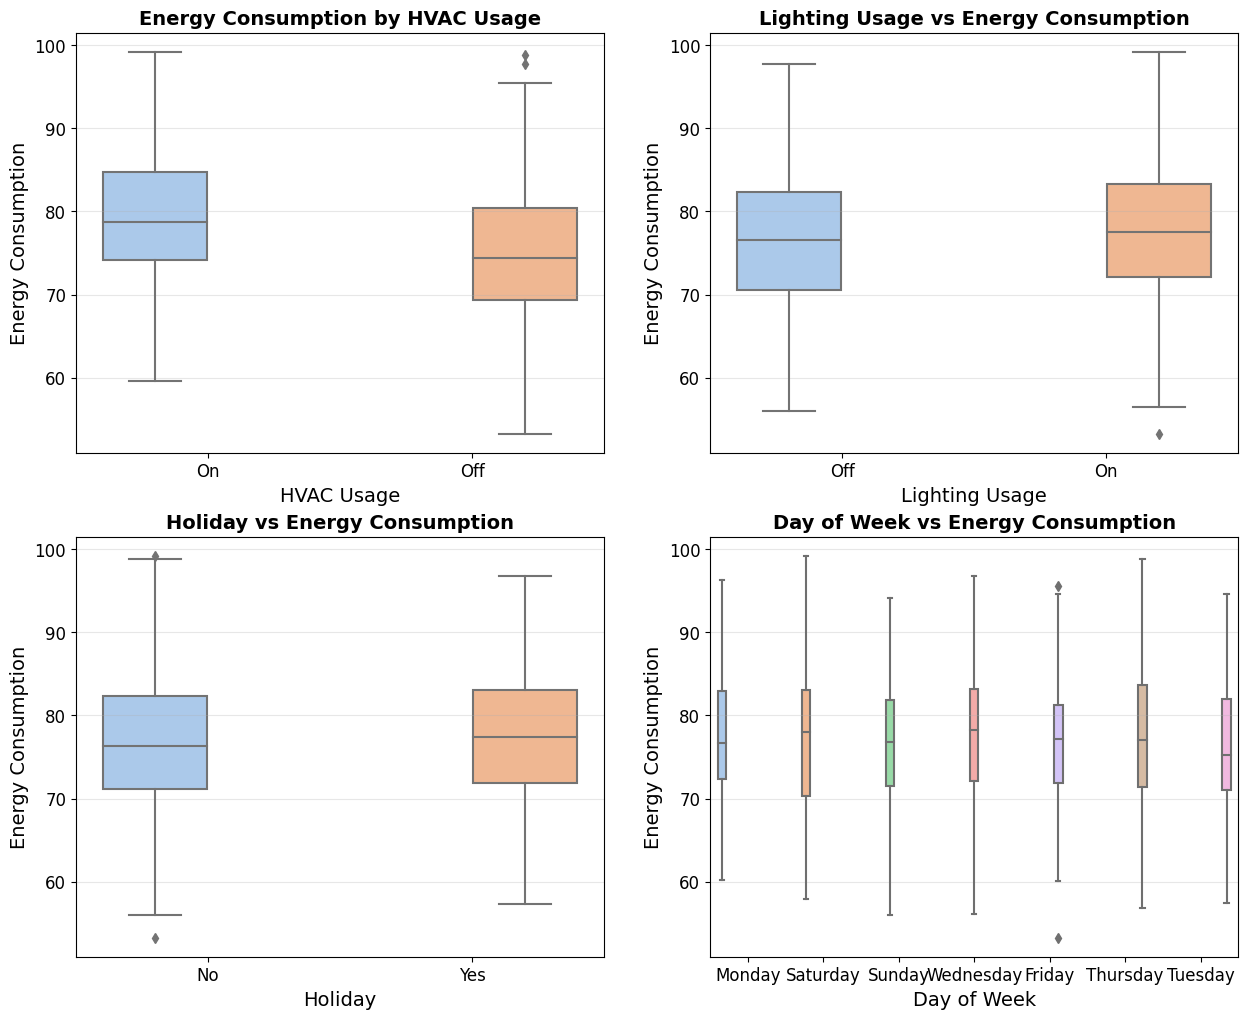

In [11]:
# Finding Outliers
fig,ax = plt.subplots(2,2, figsize = (15,12))

# HVAC Usage vs Energy Consumption
sns.boxplot(ax = ax[0,0],x = "HVACUsage",y = "EnergyConsumption",hue = "HVACUsage",data = df,palette = "pastel")
ax[0,0].set_title("Energy Consumption by HVAC Usage",fontsize = 14,fontweight = "bold")
ax[0,0].set_xlabel("HVAC Usage",fontsize = 14)
ax[0,0].set_ylabel("Energy Consumption",fontsize = 14)
ax[0,0].tick_params(axis = "x",labelsize = 12)
ax[0,0].tick_params(axis = "y",labelsize = 12)
ax[0,0].grid(axis = "y",alpha = 0.3)
ax[0,0].legend_.remove()

# Lighting Usage vs Energy Consumption
sns.boxplot(ax = ax[0,1],x = "LightingUsage",y = "EnergyConsumption",hue = "LightingUsage",data = df,palette=  "pastel")
ax[0,1].set_title("Lighting Usage vs Energy Consumption",fontsize = 14,fontweight = "bold")
ax[0,1].set_xlabel("Lighting Usage",fontsize = 14)
ax[0,1].set_ylabel("Energy Consumption",fontsize = 14)
ax[0,1].tick_params(axis = "x",labelsize = 12)
ax[0,1].tick_params(axis = "y",labelsize = 12)
ax[0,1].grid(axis = "y",alpha = 0.3)
ax[0,1].legend_.remove()

# Holiday vs Energy Consumption
sns.boxplot(ax = ax[1,0],x = "Holiday",y = "EnergyConsumption",hue = "Holiday",data = df,palette = "pastel")
ax[1,0].set_title("Holiday vs Energy Consumption",fontsize = 14,fontweight = "bold")
ax[1,0].set_xlabel("Holiday",fontsize = 14)
ax[1,0].set_ylabel("Energy Consumption",fontsize = 14)
ax[1,0].tick_params(axis = "x",labelsize = 12)
ax[1,0].tick_params(axis = "y",labelsize = 12)
ax[1,0].grid(axis = "y",alpha = 0.3)
ax[1,0].legend_.remove()

# DayofWeek vs EnergyConsumption
sns.boxplot(ax = ax[1,1],x = "DayOfWeek",y = "EnergyConsumption",hue = "DayOfWeek",data = df,palette = "pastel")
ax[1,1].set_title("Day of Week vs Energy Consumption",fontsize = 14,fontweight = "bold")
ax[1,1].set_xlabel("Day of Week",fontsize = 14)
ax[1,1].set_ylabel("Energy Consumption",fontsize = 14)
ax[1,1].tick_params(axis = "x",labelsize = 12)
ax[1,1].tick_params(axis = "y",labelsize = 12)
ax[1,1].grid(axis = "y",alpha = 0.3)
ax[1,1].legend_.remove()

In [12]:
def group_outlier_summary(df,group_col,target_col):
    summary = {}
    for group_name, group in df.groupby(group_col):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3-Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        is_outlier = (group[target_col] < lower) | (group[target_col] > upper)
        outlier_count = is_outlier.sum()
        outlier_precent = round(outlier_count/len(group)*100,2) if len(group) > 0 else 0
        summary[group_name] = {
            "outlier_count":outlier_count,
            "outlier_precent":outlier_precent
        }
    summary_df = pd.DataFrame.from_dict(summary,orient = "index")
    summary_df.index.name = group_col
    return summary_df

In [13]:
for col in cat_cols:
    print(f"Outlier summary for {col}:")
    display(group_outlier_summary(df,col,"EnergyConsumption"))

Outlier summary for HVACUsage:


,outlier_count,outlier_precent
HVACUsage,,
Off,2,0.39
On,0,0.00


Outlier summary for LightingUsage:


,outlier_count,outlier_precent
LightingUsage,,
Off,0,0.0
On,1,0.2


Outlier summary for DayOfWeek:


,outlier_count,outlier_precent
DayOfWeek,,
Friday,2,1.22
Monday,0,0.00
Saturday,0,0.00
Sunday,0,0.00
Thursday,0,0.00
Tuesday,0,0.00
Wednesday,0,0.00


Outlier summary for Holiday:


,outlier_count,outlier_precent
Holiday,,
No,2,0.38
Yes,0,0.00


In [20]:
def remove_group_outliers(df,group_col,target_col):
    def iqr_filter(group):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3-Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[target_col] >= lower) & (group[target_col] <= upper)]
    return df.groupby(group_col,group_keys = False).apply(iqr_filter)

def remove_all_group_outliers(df,cat_cols,target_col,max_iter = 2):
    prev_len = -1
    curr_df = df.copy()
    i = 0
    while prev_len != len(curr_df) and i < max_iter:
        prev_len = len(curr_df)
        clean_indices = [set(remove_group_outliers(curr_df,col,target_col).index) for col in cat_cols]
        final_indices = set.intersection(*clean_indices)
        curr_df = curr_df.loc[list(final_indices)]
        i += 1
    return curr_df
    
data_clean = remove_all_group_outliers(df,cat_cols,"EnergyConsumption")

/tmp/ipykernel_37/1995873696.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col,group_keys = False).apply(iqr_filter)
/tmp/ipykernel_37/1995873696.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col,group_keys = False).apply(iqr_filter)
/tmp/ipykernel_37/1995873696.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This

In [18]:
data_clean.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,4,1,1


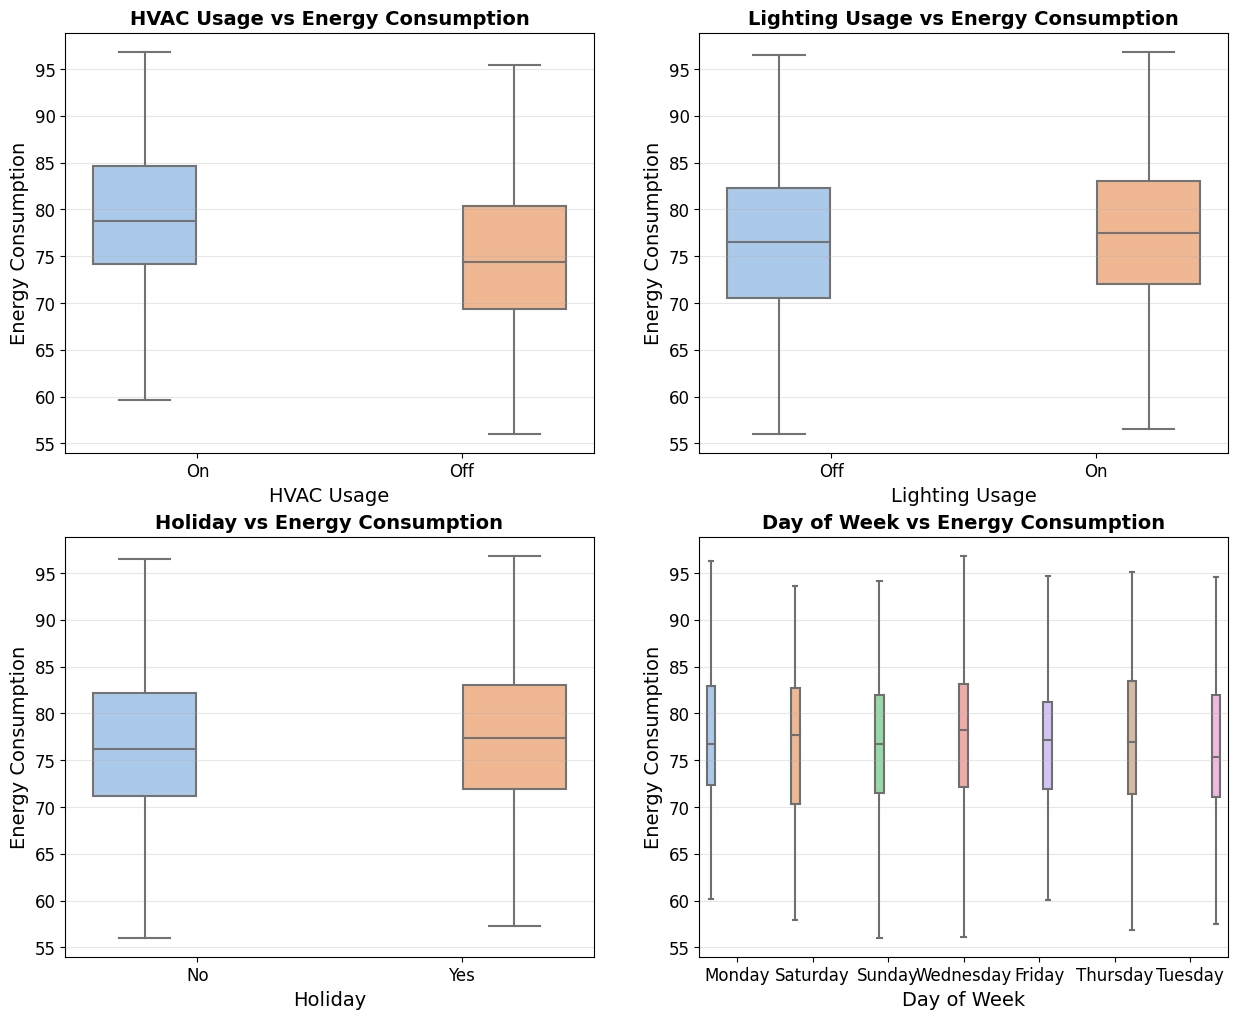

In [22]:
fig,ax = plt.subplots(2,2,figsize = (15,12))

# HVAC Usage vs Energy Consumption
sns.boxplot(ax = ax[0,0],x = "HVACUsage",y = "EnergyConsumption",hue = "HVACUsage",data = data_clean,palette = "pastel")
ax[0,0].set_title("HVAC Usage vs Energy Consumption",fontsize = 14,fontweight = "bold")
ax[0,0].set_xlabel("HVAC Usage",fontsize = 14)
ax[0,0].set_ylabel("Energy Consumption",fontsize = 14)
ax[0,0].tick_params(axis = "x",labelsize = 12)
ax[0,0].tick_params(axis = "y",labelsize = 12)
ax[0,0].grid(axis = "y",alpha = 0.3)
ax[0,0].legend_.remove()

# Lighting Usage vs Energy Consumption
sns.boxplot(ax = ax[0,1],x = "LightingUsage",y = "EnergyConsumption",hue = "LightingUsage",data = data_clean,palette=  "pastel")
ax[0,1].set_title("Lighting Usage vs Energy Consumption",fontsize = 14,fontweight = "bold")
ax[0,1].set_xlabel("Lighting Usage",fontsize = 14)
ax[0,1].set_ylabel("Energy Consumption",fontsize = 14)
ax[0,1].tick_params(axis = "x",labelsize = 12)
ax[0,1].tick_params(axis = "y",labelsize = 12)
ax[0,1].grid(axis = "y",alpha = 0.3)
ax[0,1].legend_.remove()

# Holiday vs Energy Consumption
sns.boxplot(ax = ax[1,0],x = "Holiday",y = "EnergyConsumption",hue = "Holiday",data = data_clean,palette = "pastel")
ax[1,0].set_title("Holiday vs Energy Consumption",fontsize = 14,fontweight = "bold")
ax[1,0].set_xlabel("Holiday",fontsize = 14)
ax[1,0].set_ylabel("Energy Consumption",fontsize = 14)
ax[1,0].tick_params(axis = "x",labelsize = 12)
ax[1,0].tick_params(axis = "y",labelsize = 12)
ax[1,0].grid(axis = "y",alpha = 0.3)
ax[1,0].legend_.remove()

# DayofWeek vs EnergyConsumption
sns.boxplot(ax = ax[1,1],x = "DayOfWeek",y = "EnergyConsumption",hue = "DayOfWeek",data = data_clean,palette = "pastel")
ax[1,1].set_title("Day of Week vs Energy Consumption",fontsize = 14,fontweight = "bold")
ax[1,1].set_xlabel("Day of Week",fontsize = 14)
ax[1,1].set_ylabel("Energy Consumption",fontsize = 14)
ax[1,1].tick_params(axis = "x",labelsize = 12)
ax[1,1].tick_params(axis = "y",labelsize = 12)
ax[1,1].grid(axis = "y",alpha = 0.3)
ax[1,1].legend_.remove()

Numerical Features

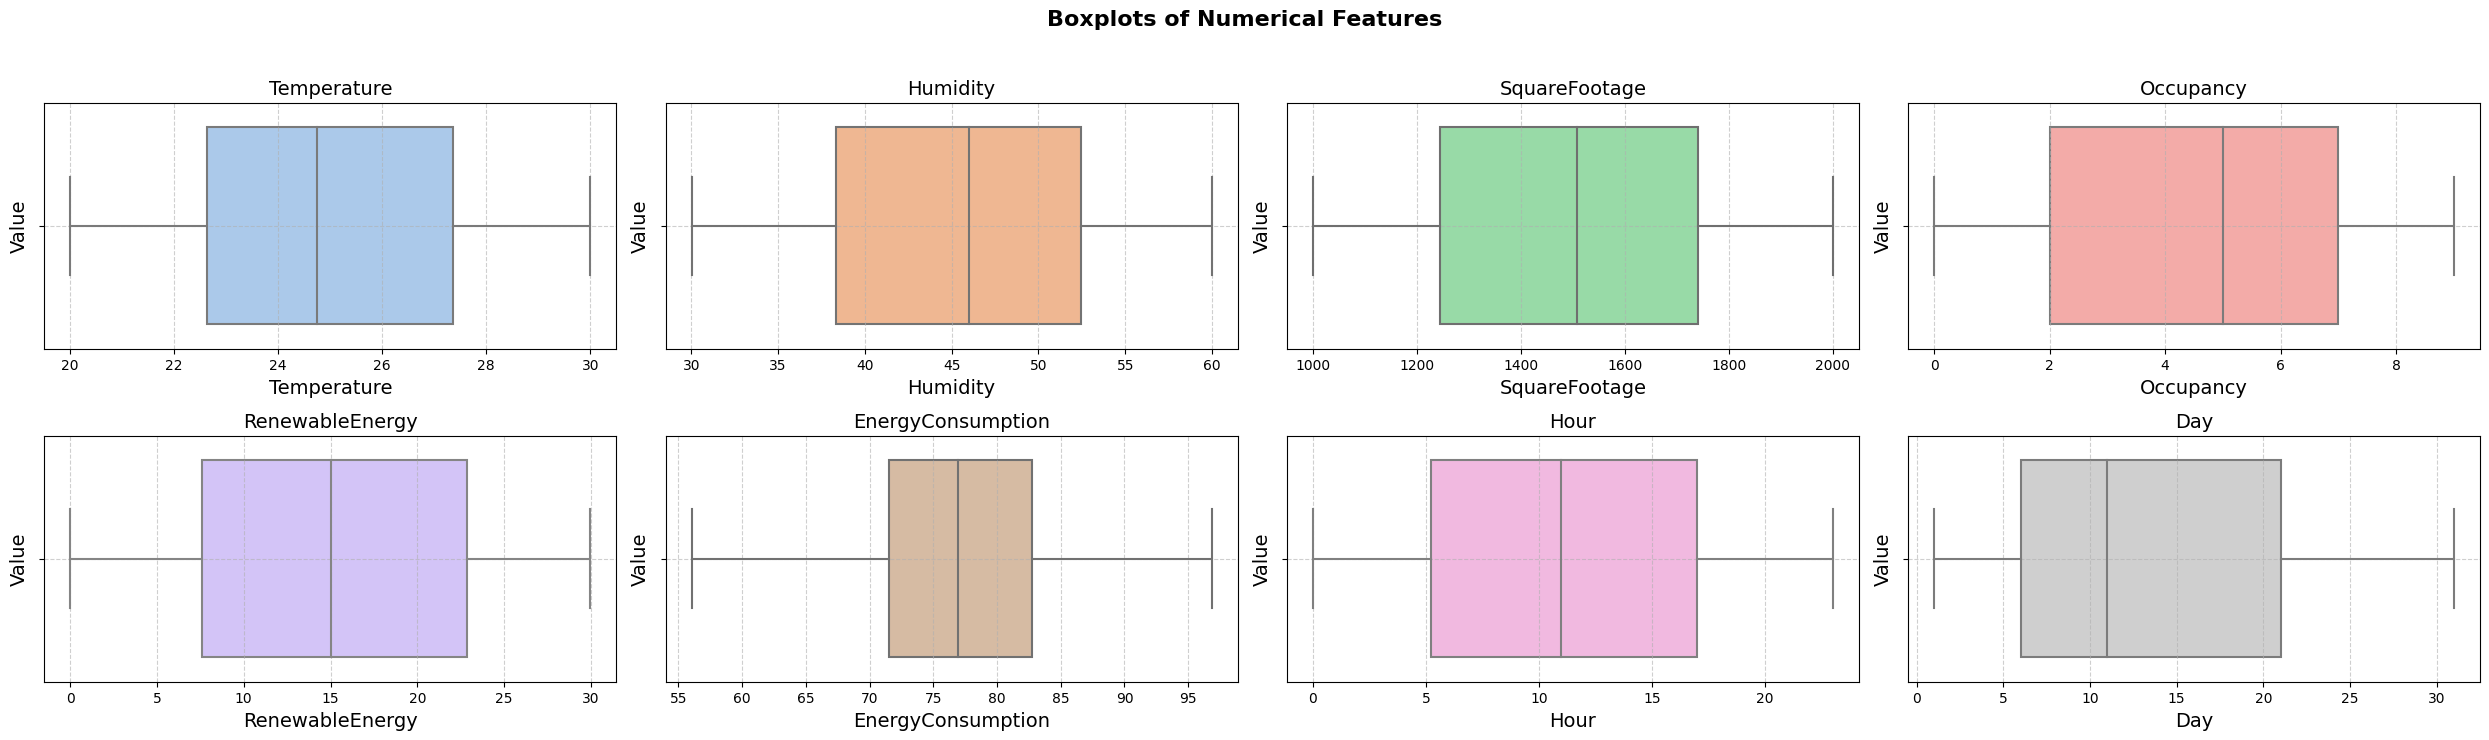

In [28]:
numerical_columns = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day']
pastel_colors = sns.color_palette("pastel",len(num_cols))
f,ax = plt.subplots(3,4,figsize = (25,10),sharey = False)
ax = ax.flatten()

for index,col in enumerate(numerical_columns):
    sns.boxplot(data = data_clean,x = col,ax = ax[index],color = pastel_colors[index])
    ax[index].set_title(col,fontsize = 14)
    ax[index].set_xlabel(col,fontsize = 14)
    ax[index].set_ylabel("Value",fontsize = 14)
    ax[index].grid(True,linestyle = "--",alpha = 0.6)

for i in range (len(numerical_columns),len(ax)):
    ax[i].set_visible(False)

f.suptitle("Boxplots of Numerical Features",fontsize = 16,fontweight = "bold",y = 1.02)
plt.tight_layout()
plt.show()

Convert Categorical Variables

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data_clean["HVACUsage"] = le.fit_transform(data_clean["HVACUsage"])
data_clean["LightingUsage"] = le.fit_transform(data_clean["LightingUsage"])
data_clean["Holiday"] = le.fit_transform(data_clean["Holiday"])

day_categories = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
data_clean["DayOfWeek"] = pd.Categorical(data_clean["DayOfWeek"],categories = day_categories,ordered = True)
data_clean["DayOfWeek"] = data_clean["DayOfWeek"].cat.codes+1

data_clean.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,6,0,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,7,0,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,3,0,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,5,0,70.811732,4,1,1


<Axes: >

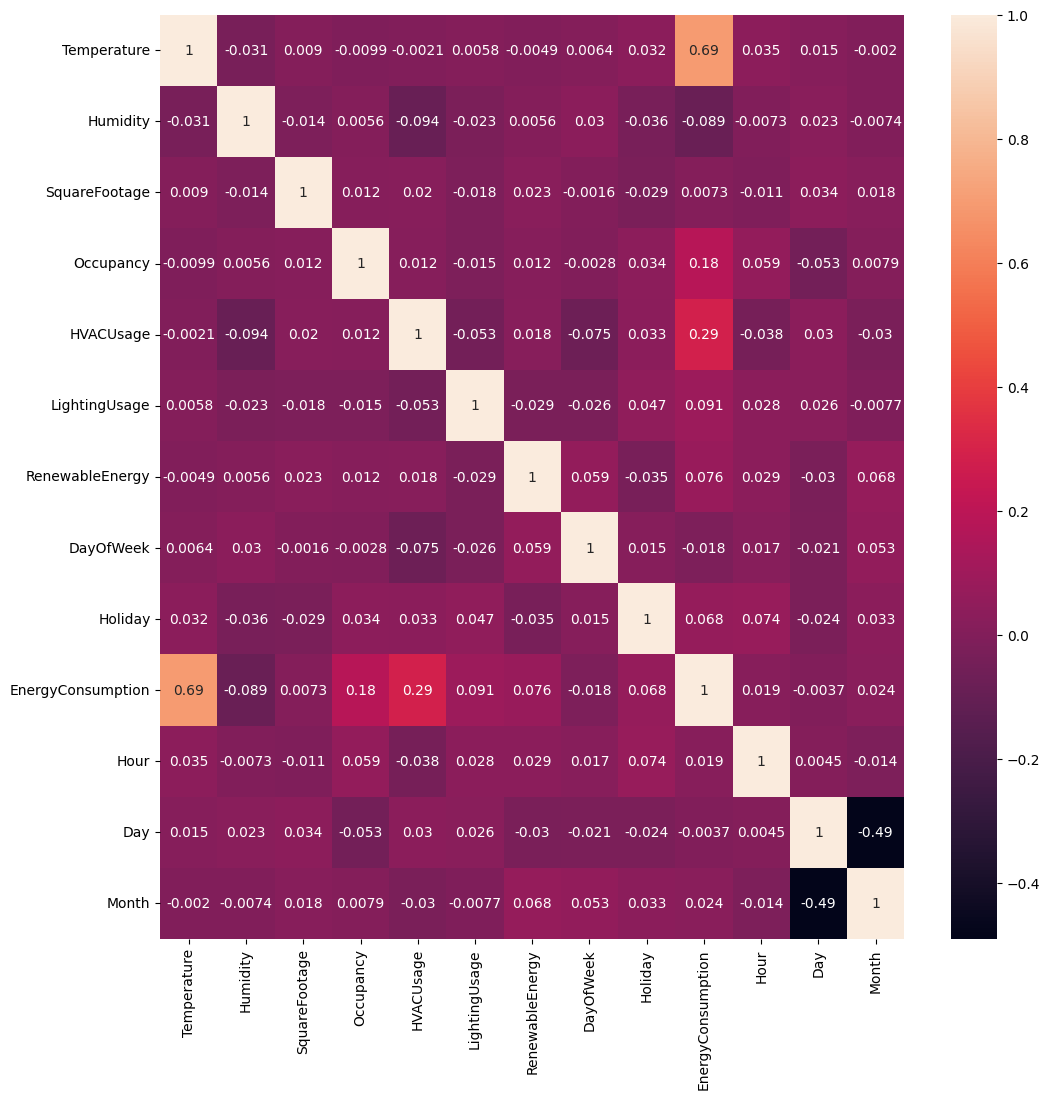

In [32]:
plt.figure(figsize = (12,12))
sns.heatmap(data_clean.corr(),annot = True)

In [33]:
X = data_clean.drop("EnergyConsumption",axis = 1)
y = data_clean["EnergyConsumption"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 2)

Scaling Values

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Modelling

In [37]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [38]:
models = {
    "Linear Regression":LinearRegression(),
    "Ridge": Ridge(alpha = 1.0),
    "Random Forest":RandomForestRegressor(n_estimators = 200,random_state = 42),
    "XGBoost":XGBRegressor(n_estimators = 300,learning_rate = 0.05,max_depth = 5,random_state = 42)
}

In [41]:
results = {}
predictions = {}

for name,model in models.items():
    if name in ["Random Forest","XGBoost"]:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled,y_train)
        y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    results[name] = {"R2":r2,"RMSE":rmse,"model":model}
    predictions[name] = y_pred
    print(f"{name:<18} | R2 : {r2:4f} | RMSE : {rmse:.2f}")

Linear Regression  | R2 : 0.513757 | RMSE : 5.02
Ridge              | R2 : 0.514014 | RMSE : 5.02
Random Forest      | R2 : 0.415741 | RMSE : 5.50
XGBoost            | R2 : 0.384857 | RMSE : 5.65


In [49]:
model1 = Ridge()
model1.fit(X_train,y_train)
model1.score(X_test,y_test)

0.5237657059872584

In [43]:
model2 = LinearRegression()
model2.fit(X_train,y_train)
model2.score(X_test,y_test)

0.5241080380433281